In [190]:
import sys
import glob
import numpy as np
import pandas as pd
import xarray as xr 
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from matplotlib import animation, rc

sys.path.append('../../src/plotting/')

from plot_spinup import make_colorbar

plt.rcParams['text.usetex'] = True
plt.rcParams['animation.html'] = 'jshtml'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def make_colorbar(mf_dataset):
    #---------------------------------------------------------------------------
    # For Seting up the colorbar:
    #    - http://csc.ucdavis.edu/~jmahoney/matplotlib-tips.html
    #---------------------------------------------------------------------------
    cmap = cm.plasma
    norm = mcolors.Normalize(vmin=np.min(mf_dataset.Delta_MB),
                                  vmax=np.max(mf_dataset.Delta_MB))

    s_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    s_map.set_array(mf_dataset.Delta_MB)

    # If color parameters is a linspace, we can set boundaries in this way
    halfdist = (mf_dataset.Delta_MB[1] - mf_dataset.Delta_MB[0]) / 2.0
    bounds   = np.linspace(mf_dataset.Delta_MB[0]   - halfdist,
                           mf_dataset.Delta_MB[-1]  + halfdist,
                           len(mf_dataset.Delta_MB) + 1)

    return cmap, norm, s_map, bounds

In [197]:
    halfdist = (mf_dataset.Delta_MB[1] - mf_dataset.Delta_MB[0]) / 2.0

    bounds   = np.linspace(mf_dataset.Delta_MB[0]   - halfdist,
                           mf_dataset.Delta_MB[-1]  + halfdist,
                           len(mf_dataset.Delta_MB) + 1)

In [198]:
bounds

array([-0.9875, -1.0125, -1.0375, -1.0625, -1.0875, -1.1125, -1.1375,
       -1.1625, -1.1875, -1.2125, -1.2375, -1.2625, -1.2875, -1.3125,
       -1.3375, -1.3625, -1.3875, -1.4125, -1.4375, -1.4625, -1.4875,
       -1.5125])

## Steady-State Velocity 

In [191]:
ss_fp = "../../initialization/coarse/result/glc1-a/nc/glc1-a_3000a_dt_1_dx_50_MB_-1.175_OFF_spline_k2.nc"
with xr.open_dataset(fp) as src: 
    # correct for minimum ice thickness
    src["height"] = xr.where(src.height <= 10, 0, src.height)
    # apply sigma coordinate transform for vertical coordinate
    src["Z"]      = src.zbed + src.Z * src.height 
    # Calculate the magnitude of the velocity vectors
    src['vel_m']  = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2)  

In [192]:
sources = []

ss_fp = "../../initialization/coarse/result/glc1-a/nc/glc1-a_3000a_dt_1_dx_50_MB_*_OFF_spline_k2.nc"

for fp in sorted(glob.glob(ss_fp)):
    with xr.open_dataset(fp) as src: 
        # correct for minimum ice thickness
        src["height"] = xr.where(src.height <= 10, 0, src.height)
        # apply sigma coordinate transform for vertical coordinate
        src["Z"]      = src.zbed + src.Z * src.height 
        # Calculate the magnitude of the velocity vectors
        src['vel_m']  = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2)  
        sources.append(src)
    
mf_dataset = xr.concat(sources,
                       pd.Index(data = np.linspace(-1., -1.5, 21),
                                name = 'Delta_MB'))

Vol = mf_dataset.isel(coord_2=-1).height.integrate('coord_1') / \
      mf_dataset.isel(coord_2=-1, t=0).height.integrate('coord_1')

In [201]:
bounds

array([-0.9875, -1.0125, -1.0375, -1.0625, -1.0875, -1.1125, -1.1375,
       -1.1625, -1.1875, -1.2125, -1.2375, -1.2625, -1.2875, -1.3125,
       -1.3375, -1.3625, -1.3875, -1.4125, -1.4375, -1.4625, -1.4875,
       -1.5125])

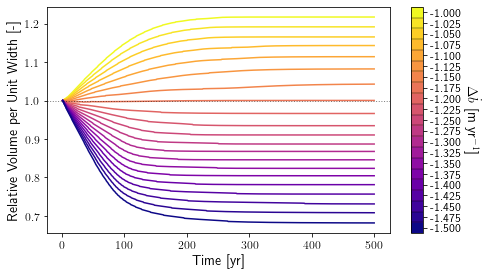

In [206]:
fig, ax = plt.subplots(figsize=(7, 4))

plt.rcParams['text.usetex'] = True

# Make a colormap and all the associated var names
cmap, norm, s_map, bounds = make_colorbar(mf_dataset)
    
for delta_mb in Vol.Delta_MB:
    color = cmap(norm(delta_mb))
    ax.plot(Vol.t.sel(t=slice(0,5e2)), 
                       Vol.sel(Delta_MB=delta_mb, t=slice(0,5e2)), color=color)

ax.axhline(1.0,c='k',ls=':',lw=1, alpha=0.5)

cbar = fig.colorbar(s_map,
                spacing='proportional',
                ticks=mf_dataset.Delta_MB,
                ax=ax,
                boundaries=bounds[::-1],
                drawedges=True,
                format='%2.3f')

# annotate the figures axes
ax.set_ylabel('Relative Volume per Unit Width [-]')
ax.set_xlabel('Time [yr]')
# annotate the colorbar axes
cbar.set_label('$\Delta \dot{b}$ [m yr$^{-1}$]', rotation=270, labelpad=20)
#cbar.ax.tick_params(labelsize=7)

fig.tight_layout()


fig.savefig('./figs/A_mean_gridsearch.pdf',
            dpi=400, 
            bbox_inches='tight',
            facecolor='w')

In [170]:
# subset the nc of all the nc's
spinup = mf_dataset.sel(Delta_MB=-1.475).isel(t=slice(0,510,5))

fig, ax = plt.subplots(figsize=(6,3), constrained_layout=True)

vmin = spinup["vel_m"].min()
vmax = spinup["vel_m"].max()

contour_opts = {'levels' : np.linspace(vmin, vmax, 101),
                'vmin'   : vmin, 
                'vmax'   : vmax,
                'cmap'   : 'magma'}

# Plot the initial condition
cax = ax.contourf(spinup.X[::-1,:]/1e3, 
                  spinup.Z.isel(t=0),
                  spinup["vel_m"].isel(t=0),
                  **contour_opts)

ax.plot(surf[::-1,0] / 1e3, surf[:,1], 'k:', lw=0.75, label="$z_{\\rm s}(t=0)$")

# Set up the colorbar
cbar = fig.colorbar(cax, 
                    ticks = np.linspace(0, 30, 7))

cbar.set_label('Velocity [m yr$^-1$]', rotation=270, labelpad=20)

ax.set_xlim(None, 5)
ax.set_ylim(1950, None)

ax.set_ylabel('Elevation [m a.s.l.]')
ax.set_xlabel('Distance along flowline [km]')

ax.fill_between(bed[::-1,0] / 1e3, bed[:,1].min()*np.ones_like(bed[:,1]), 
            bed[:,1]-5.0, color='saddlebrown', alpha=0.5)

# Add time annotation
label = ax.text(0.1, 0.15, r"$t=0$",
                transform=ax.transAxes,
                ha='center', va='center')

ax.set_title('$\Delta \dot{b} = -1.475$')
ax.legend()
plt.close()
def animate(i):
    # Wipe the axis
    ax.collections = []
    # Plot the contour
    ax.contourf(spinup.X[::-1,:]/1e3, 
                spinup.Z.isel(t=i),
                spinup["vel_m"].isel(t=i),
                **contour_opts)
    # Update time annotation
    label.set_text("$t={{{:6.1f}}}$".format(spinup.t[i].values-1))
    ax.fill_between(bed[::-1,0] / 1e3, bed[:,1].min()*np.ones_like(bed[:,1]), 
            bed[:,1]-5.0, color='saddlebrown', alpha=0.5)


anim = animation.FuncAnimation(
    fig, animate, interval=150, frames=len(spinup.t)-1)

anim.save('./figs/uncoupled_spinup_-1.475.mp4', dpi=800)

In [171]:
# subset the nc of all the nc's
spinup = mf_dataset.sel(Delta_MB=-1.175).isel(t=slice(0,510,5))

fig, ax = plt.subplots(figsize=(6,3), constrained_layout=True)

vmin = spinup["vel_m"].min()
vmax = spinup["vel_m"].max()

contour_opts = {'levels' : np.linspace(vmin, vmax, 101),
                'vmin'   : vmin, 
                'vmax'   : vmax,
                'cmap'   : 'magma'}

# Plot the initial condition
cax = ax.contourf(spinup.X[::-1,:]/1e3, 
                  spinup.Z.isel(t=0),
                  spinup["vel_m"].isel(t=0),
                  **contour_opts)

ax.plot(surf[::-1,0] / 1e3, surf[:,1], 'k:', lw=0.75, label="$z_{\\rm s}(t=0)$")

# Set up the colorbar
cbar = fig.colorbar(cax, 
                    ticks = np.linspace(0, 30, 7))

cbar.set_label('Velocity [m yr$^-1$]', rotation=270, labelpad=20)

ax.set_xlim(None, 5)
ax.set_ylim(1950, None)

ax.set_ylabel('Elevation [m a.s.l.]')
ax.set_xlabel('Distance along flowline [km]')

ax.fill_between(bed[::-1,0] / 1e3, bed[:,1].min()*np.ones_like(bed[:,1]), 
            bed[:,1]-5.0, color='saddlebrown', alpha=0.5)

# Add time annotation
label = ax.text(0.1, 0.15, r"$t=0$",
                transform=ax.transAxes,
                ha='center', va='center')

ax.set_title('$\Delta \dot{b} = -1.175$')
ax.legend()
plt.close()
def animate(i):
    # Wipe the axis
    ax.collections = []
    # Plot the contour
    ax.contourf(spinup.X[::-1,:]/1e3, 
                spinup.Z.isel(t=i),
                spinup["vel_m"].isel(t=i),
                **contour_opts)
    # Update time annotation
    label.set_text("$t={{{:6.1f}}}$".format(spinup.t[i].values-1))
    ax.fill_between(bed[::-1,0] / 1e3, bed[:,1].min()*np.ones_like(bed[:,1]), 
            bed[:,1]-5.0, color='saddlebrown', alpha=0.5)


anim = animation.FuncAnimation(
    fig, animate, interval=150, frames=len(spinup.t)-1)

anim.save('./figs/uncoupled_spinup_-1.175.mp4', dpi=800)

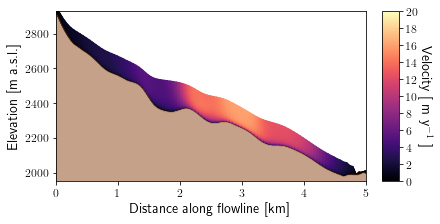

In [121]:
contourf_kwargs = {
    'cmap'   : 'magma',
    'shading': "gouraud",
    'clim'   : (0, 20.0), 
    'vmin'   : 0.0, 
    'vmax'   : 20.0
    #'levels' : np.linspace(-12, 0.0, 81), 
    #'extend' : 'min'
    }

fig, ax = plt.subplots(1,1, figsize=(6,3), 
                       constrained_layout=True)

im = ax.pcolormesh(src.X[::-1,:] / 1e3, 
             src.Z.isel(t=-1),
             src['vel_m'].isel(t=-1),
             **contourf_kwargs)

cbar = fig.colorbar(im, 
                    ax = ax, 
                    ticks = np.linspace(0, 20.0, 11), 
                   )

cbar.set_label('Velocity [ m y$^{-1}$ ]', rotation=270, labelpad=15)

# ax.text(0.15, 0.9, label,
#         transform=ax.transAxes,
#         ha='left', va='center')

ax.set_xlim(None, 5)
ax.set_ylim(1950, None)

ax.set_ylabel('Elevation [m a.s.l.]')
ax.set_xlabel('Distance along flowline [km]')

ax.fill_between(bed[::-1,0] / 1e3, bed[:,1].min()*np.ones_like(bed[:,1]), 
            bed[:,1]-5.0, color='saddlebrown', alpha=0.5)

fig.savefig(f'./figs/heatsources_Step0.pdf',
    dpi = 400, bbox_inches='tight',
    facecolor='w')

In [118]:
src['vel_m'].max()

<xarray.DataArray 'vel_m' ()>
array(22.66640472)

In [164]:
sources = []

for fp in sorted(glob.glob("./glc1-a/nc/heat_sources_step*_T_-7.02.nc")):
    with xr.open_dataset(fp) as src: 
        # correct for minimum ice thickness
        src["height"] = xr.where(src.height <= 10, 0, src.height)
        src["Z"]     = src.zbed + src.Z * src.height 
        src['vel_m'] = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2)

        sources.append(src)
    
heat_sources = xr.concat(sources, 
                         pd.Index(data = [f'Step{i+1}' for i in range(len(sources))],
                                  name = 'step'))

x_coord   = heat_sources.sel(step='Step1').X[::-1,:].isel(coord_2 = -1).values / 1e3
z_s_coord = heat_sources.sel(step='Step1').Z[::-1,:].isel(t=-1, coord_2 = -1).values
z_b_coord = heat_sources.sel(step='Step1').zbed[::-1,:].isel(t=-1, coord_2 = -1).values

In [165]:
cold_color  = plt.cm.viridis(np.linspace(0.00, 1.00, 256))
temp_color  = plt.cm.Blues(  np.linspace(0.00, 1.00, 256))
poly_color  = np.vstack((cold_color, temp_color))
polythermal = mcolors.LinearSegmentedColormap.from_list('polythermal', poly_color)
divnorm     = mcolors.TwoSlopeNorm(vmin=-10., vcenter=0.0, vmax=3.0)

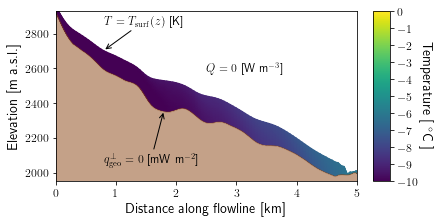

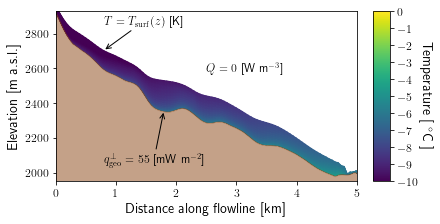

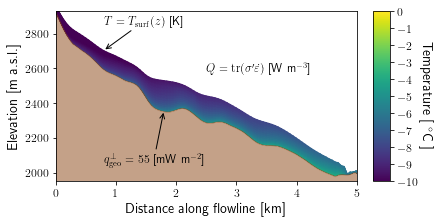

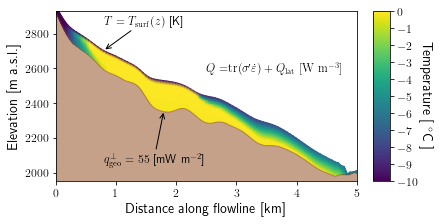

In [182]:
contourf_kwargs = {
    'cmap'   : 'viridis',
    'shading': "gouraud",
    'clim'   : (-10.0, 0.0), 
    'vmin'   : -10.0, 
    'vmax'   : 0.0
    #'levels' : np.linspace(-12, 0.0, 81), 
    #'extend' : 'min'
    }

def plot_temp(step, time, contourf_kwargs = {None : None}, label = None):
    fig, ax = plt.subplots(1,1, figsize=(6,3), 
                           constrained_layout=True)
    
    im = ax.pcolormesh(heat_sources.sel(step=step).X[::-1,:] / 1e3, 
                 heat_sources.sel(step=step).Z.sel(t=time),
                 heat_sources.sel(step=step)['temperature'].sel(t=time),
                 **contourf_kwargs)

    cbar = fig.colorbar(im, 
                        ax = ax, 
                        ticks = np.linspace(-10, 0.0, 11), 
                       )

    cbar.set_label('Temperature [ $^{\circ}$C ]', rotation=270, labelpad=15)

    # ax.text(0.15, 0.9, label,
    #         transform=ax.transAxes,
    #         ha='left', va='center')
    
    ax.set_xlim(None, 5)
    ax.set_ylim(1950, None)

    ax.set_ylabel('Elevation [m a.s.l.]')
    ax.set_xlabel('Distance along flowline [km]')
    
    ax.fill_between(bed[::-1,0] / 1e3, bed[:,1].min()*np.ones_like(bed[:,1]), 
                bed[:,1]-5.0, color='saddlebrown', alpha=0.5)
    
    return fig, ax 
    
times  = [50, 50, 50, 50]
labels = ['Step 1: Dirichlet B.C. for surface temperature and no geothermal heat flux',
          'Step 2: Dirichlet B.C. for surface temperature and a geothermal heat flux',
          'Step 3: Dirichlet B.C. for surface temperature, a geothermal heat flux\n\
          and deformation heating',
          'Step 4: Dirichlet B.C. for surface temp, a geothermal heat flux, \n\
          deformation heating, and meltwater percolation.'] 

bed  = np.loadtxt('../../input_data/topography/glc1-a_bed.dat')
surf = np.loadtxt('../../input_data/topography/glc1-a_surf.dat')

for i in np.arange(0, 4, dtype=np.int):
    step  = f"Step{i+1}"

    fig, ax = plot_temp(step, times[i], contourf_kwargs, labels[i])
    
    ax.annotate(r"$T=T_{\rm surf}(z)$ [K]", 
                xy=(x_coord[130], z_coord[130]), 
                xytext=(x_coord[130], z_coord[130]+150),
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    
    if i < 1: 
        ax.annotate(r"$q^{\perp}_{\rm geo}=0$ [mW m$^{-2}$]", 
            xy=(x_coord[110], z_b_coord[110]), 
            xytext=(x_coord[110]-1., z_b_coord[110]-300),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    else: 
        ax.annotate(r"$q^{\perp}_{\rm geo}=55$ [mW m$^{-2}$]", 
            xy=(x_coord[110], z_b_coord[110]), 
            xytext=(x_coord[110]-1., z_b_coord[110]-300),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
        
    if i < 2: 
        ax.text(2.5, 2600, r"$Q = 0$ [W m$^{-3}$]",
        horizontalalignment="left", verticalalignment="center",
        clip_on=False)

    elif i == 2: 
        ax.text(2.5, 2600, r"$Q = \rm{tr}(\sigma' \dot{\varepsilon})$ [W m$^{-3}$]",
        horizontalalignment="left", verticalalignment="center",
        clip_on=False)        
        
    else: 
        ax.text(2.5, 2600, r"$Q = $\rm{tr}$(\sigma' \dot{\varepsilon}) + Q_{\rm lat}$ [W m$^{-3}$]",
        horizontalalignment="left", verticalalignment="center",
        clip_on=False)         
        
    fig.savefig(f'./figs/heatsources_{step}.pdf',
        dpi = 400, bbox_inches='tight',
        facecolor='w')